# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
            #print(pred.size())
           
            loss += MRELoss(pred, y).item()
            #loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        #loss = loss_fn(pred, y) # Calculate the loss
        loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 2.7386
Epoch 1/200, Iteration 2/25, Loss: 121.0464
Epoch 1/200, Iteration 3/25, Loss: 110.1039
Epoch 1/200, Iteration 4/25, Loss: 47.3358
Epoch 1/200, Iteration 5/25, Loss: 44.5743
Epoch 1/200, Iteration 6/25, Loss: 97.2953
Epoch 1/200, Iteration 7/25, Loss: 38.9107
Epoch 1/200, Iteration 8/25, Loss: 47.2981
Epoch 1/200, Iteration 9/25, Loss: 76.5271
Epoch 1/200, Iteration 10/25, Loss: 127.5188
Epoch 1/200, Iteration 11/25, Loss: 40.7916
Epoch 1/200, Iteration 12/25, Loss: 49.3357
Epoch 1/200, Iteration 13/25, Loss: 99.6150
Epoch 1/200, Iteration 14/25, Loss: 52.9666
Epoch 1/200, Iteration 15/25, Loss: 75.0723
Epoch 1/200, Iteration 16/25, Loss: 25.4174
Epoch 1/200, Iteration 17/25, Loss: 16.9728
Epoch 1/200, Iteration 18/25, Loss: 55.4957
Epoch 1/200, Iteration 19/25, Loss: 31.2076
Epoch 1/200, Iteration 20/25, Loss: 36.8793
Epoch 1/200, Iteration 21/25, Loss: 13.2349
Epoch 1/200, Iteration 22/25, Loss: 12.2807
Epoch 1/200, Iteration 23/25, Loss: 42.

Train Error: 
 Accuracy: 27.88%, Avg loss: 51.772384, MRE: 51.772384 

Test Error: 
 Accuracy: 28.0%, Avg loss: 101.169489, MRE: 101.169489 

Epoch 8/200, Iteration 1/25, Loss: 57.9257
Epoch 8/200, Iteration 2/25, Loss: 62.9006
Epoch 8/200, Iteration 3/25, Loss: 61.1737
Epoch 8/200, Iteration 4/25, Loss: 66.8813
Epoch 8/200, Iteration 5/25, Loss: 51.9271
Epoch 8/200, Iteration 6/25, Loss: 42.5370
Epoch 8/200, Iteration 7/25, Loss: 39.1509
Epoch 8/200, Iteration 8/25, Loss: 46.4139
Epoch 8/200, Iteration 9/25, Loss: 21.7093
Epoch 8/200, Iteration 10/25, Loss: 11.8262
Epoch 8/200, Iteration 11/25, Loss: 6.9278
Epoch 8/200, Iteration 12/25, Loss: 9.6770
Epoch 8/200, Iteration 13/25, Loss: 20.1374
Epoch 8/200, Iteration 14/25, Loss: 154.3586
Epoch 8/200, Iteration 15/25, Loss: 11.0672
Epoch 8/200, Iteration 16/25, Loss: 42.3937
Epoch 8/200, Iteration 17/25, Loss: 9.2681
Epoch 8/200, Iteration 18/25, Loss: 16.0874
Epoch 8/200, Iteration 19/25, Loss: 31.8502
Epoch 8/200, Iteration 20/25, Los

Train Error: 
 Accuracy: 85.25%, Avg loss: 16.699901, MRE: 16.699901 

Test Error: 
 Accuracy: 82.0%, Avg loss: 35.611151, MRE: 35.611151 

Epoch 15/200, Iteration 1/25, Loss: 20.7855
Epoch 15/200, Iteration 2/25, Loss: 3.2675
Epoch 15/200, Iteration 3/25, Loss: 11.6030
Epoch 15/200, Iteration 4/25, Loss: 37.4993
Epoch 15/200, Iteration 5/25, Loss: 24.4674
Epoch 15/200, Iteration 6/25, Loss: 77.8961
Epoch 15/200, Iteration 7/25, Loss: 5.7027
Epoch 15/200, Iteration 8/25, Loss: 10.2171
Epoch 15/200, Iteration 9/25, Loss: 19.2285
Epoch 15/200, Iteration 10/25, Loss: 24.0682
Epoch 15/200, Iteration 11/25, Loss: 18.4151
Epoch 15/200, Iteration 12/25, Loss: 6.8332
Epoch 15/200, Iteration 13/25, Loss: 4.5649
Epoch 15/200, Iteration 14/25, Loss: 5.7154
Epoch 15/200, Iteration 15/25, Loss: 10.3578
Epoch 15/200, Iteration 16/25, Loss: 4.6258
Epoch 15/200, Iteration 17/25, Loss: 10.8001
Epoch 15/200, Iteration 18/25, Loss: 10.2364
Epoch 15/200, Iteration 19/25, Loss: 8.1918
Epoch 15/200, Iterati

Epoch 21/200, Iteration 21/25, Loss: 15.3029
Epoch 21/200, Iteration 22/25, Loss: 71.4197
Epoch 21/200, Iteration 23/25, Loss: 8.3043
Epoch 21/200, Iteration 24/25, Loss: 118.8147
Epoch 21/200, Iteration 25/25, Loss: 13.6598
Train Error: 
 Accuracy: 55.25%, Avg loss: 9.774351, MRE: 9.774351 

Test Error: 
 Accuracy: 55.5%, Avg loss: 26.702230, MRE: 26.702230 

Epoch 22/200, Iteration 1/25, Loss: 5.1955
Epoch 22/200, Iteration 2/25, Loss: 9.5654
Epoch 22/200, Iteration 3/25, Loss: 18.3239
Epoch 22/200, Iteration 4/25, Loss: 9.0497
Epoch 22/200, Iteration 5/25, Loss: 5.0826
Epoch 22/200, Iteration 6/25, Loss: 3.4812
Epoch 22/200, Iteration 7/25, Loss: 3.7813
Epoch 22/200, Iteration 8/25, Loss: 9.8966
Epoch 22/200, Iteration 9/25, Loss: 10.8703
Epoch 22/200, Iteration 10/25, Loss: 10.2250
Epoch 22/200, Iteration 11/25, Loss: 5.3415
Epoch 22/200, Iteration 12/25, Loss: 4.1145
Epoch 22/200, Iteration 13/25, Loss: 21.5277
Epoch 22/200, Iteration 14/25, Loss: 14.4106
Epoch 22/200, Iteration 1

Epoch 29/200, Iteration 7/25, Loss: 7.8546
Epoch 29/200, Iteration 8/25, Loss: 12.5054
Epoch 29/200, Iteration 9/25, Loss: 23.8256
Epoch 29/200, Iteration 10/25, Loss: 18.4601
Epoch 29/200, Iteration 11/25, Loss: 12.5775
Epoch 29/200, Iteration 12/25, Loss: 29.0452
Epoch 29/200, Iteration 13/25, Loss: 26.8506
Epoch 29/200, Iteration 14/25, Loss: 9.1695
Epoch 29/200, Iteration 15/25, Loss: 16.6468
Epoch 29/200, Iteration 16/25, Loss: 19.4349
Epoch 29/200, Iteration 17/25, Loss: 9.2934
Epoch 29/200, Iteration 18/25, Loss: 11.7931
Epoch 29/200, Iteration 19/25, Loss: 258.6947
Epoch 29/200, Iteration 20/25, Loss: 117.9383
Epoch 29/200, Iteration 21/25, Loss: 6.5329
Epoch 29/200, Iteration 22/25, Loss: 21.3513
Epoch 29/200, Iteration 23/25, Loss: 70.1181
Epoch 29/200, Iteration 24/25, Loss: 14.7412
Epoch 29/200, Iteration 25/25, Loss: 13.1050
Train Error: 
 Accuracy: 15.38%, Avg loss: 39.975056, MRE: 39.975056 

Test Error: 
 Accuracy: 13.5%, Avg loss: 84.309250, MRE: 84.309250 

Epoch 30/2

Epoch 36/200, Iteration 10/25, Loss: 1.5311
Epoch 36/200, Iteration 11/25, Loss: 1.6979
Epoch 36/200, Iteration 12/25, Loss: 1.4107
Epoch 36/200, Iteration 13/25, Loss: 1.6719
Epoch 36/200, Iteration 14/25, Loss: 3.5632
Epoch 36/200, Iteration 15/25, Loss: 2.4266
Epoch 36/200, Iteration 16/25, Loss: 6.5902
Epoch 36/200, Iteration 17/25, Loss: 1.9168
Epoch 36/200, Iteration 18/25, Loss: 2.6823
Epoch 36/200, Iteration 19/25, Loss: 1.3828
Epoch 36/200, Iteration 20/25, Loss: 3.3767
Epoch 36/200, Iteration 21/25, Loss: 17.1685
Epoch 36/200, Iteration 22/25, Loss: 7.2093
Epoch 36/200, Iteration 23/25, Loss: 4.3889
Epoch 36/200, Iteration 24/25, Loss: 7.4029
Epoch 36/200, Iteration 25/25, Loss: 9.5730
Train Error: 
 Accuracy: 27.12%, Avg loss: 9.519851, MRE: 9.519851 

Test Error: 
 Accuracy: 28.5%, Avg loss: 15.230032, MRE: 15.230032 

Epoch 37/200, Iteration 1/25, Loss: 8.1149
Epoch 37/200, Iteration 2/25, Loss: 4.3687
Epoch 37/200, Iteration 3/25, Loss: 15.9988
Epoch 37/200, Iteration 4/2

Epoch 44/200, Iteration 8/25, Loss: 1.3403
Epoch 44/200, Iteration 9/25, Loss: 1.2437
Epoch 44/200, Iteration 10/25, Loss: 1.4374
Epoch 44/200, Iteration 11/25, Loss: 3.2023
Epoch 44/200, Iteration 12/25, Loss: 2.5957
Epoch 44/200, Iteration 13/25, Loss: 4.3024
Epoch 44/200, Iteration 14/25, Loss: 3.4895
Epoch 44/200, Iteration 15/25, Loss: 2.4510
Epoch 44/200, Iteration 16/25, Loss: 7.4022
Epoch 44/200, Iteration 17/25, Loss: 4.2964
Epoch 44/200, Iteration 18/25, Loss: 1.0546
Epoch 44/200, Iteration 19/25, Loss: 2.8719
Epoch 44/200, Iteration 20/25, Loss: 1.8681
Epoch 44/200, Iteration 21/25, Loss: 2.5158
Epoch 44/200, Iteration 22/25, Loss: 5.9573
Epoch 44/200, Iteration 23/25, Loss: 4.0498
Epoch 44/200, Iteration 24/25, Loss: 4.7273
Epoch 44/200, Iteration 25/25, Loss: 21.6152
Train Error: 
 Accuracy: 62.62%, Avg loss: 3.568362, MRE: 3.568362 

Test Error: 
 Accuracy: 57.5%, Avg loss: 8.775461, MRE: 8.775461 

Epoch 45/200, Iteration 1/25, Loss: 6.0427
Epoch 45/200, Iteration 2/25, 

Epoch 51/200, Iteration 17/25, Loss: 1.1724
Epoch 51/200, Iteration 18/25, Loss: 1.9229
Epoch 51/200, Iteration 19/25, Loss: 4.4786
Epoch 51/200, Iteration 20/25, Loss: 3.6797
Epoch 51/200, Iteration 21/25, Loss: 2.7213
Epoch 51/200, Iteration 22/25, Loss: 2.3151
Epoch 51/200, Iteration 23/25, Loss: 1.1959
Epoch 51/200, Iteration 24/25, Loss: 6.6000
Epoch 51/200, Iteration 25/25, Loss: 2.0467
Train Error: 
 Accuracy: 51.0%, Avg loss: 2.270030, MRE: 2.270030 

Test Error: 
 Accuracy: 44.5%, Avg loss: 5.989784, MRE: 5.989784 

Epoch 52/200, Iteration 1/25, Loss: 0.9956
Epoch 52/200, Iteration 2/25, Loss: 2.3371
Epoch 52/200, Iteration 3/25, Loss: 1.2525
Epoch 52/200, Iteration 4/25, Loss: 1.1452
Epoch 52/200, Iteration 5/25, Loss: 1.6595
Epoch 52/200, Iteration 6/25, Loss: 1.6659
Epoch 52/200, Iteration 7/25, Loss: 0.9137
Epoch 52/200, Iteration 8/25, Loss: 4.4275
Epoch 52/200, Iteration 9/25, Loss: 1.1429
Epoch 52/200, Iteration 10/25, Loss: 4.8008
Epoch 52/200, Iteration 11/25, Loss: 1

Epoch 59/200, Iteration 11/25, Loss: 16.9214
Epoch 59/200, Iteration 12/25, Loss: 7.1746
Epoch 59/200, Iteration 13/25, Loss: 25.9356
Epoch 59/200, Iteration 14/25, Loss: 5.4817
Epoch 59/200, Iteration 15/25, Loss: 2.7714
Epoch 59/200, Iteration 16/25, Loss: 1.8218
Epoch 59/200, Iteration 17/25, Loss: 2.6922
Epoch 59/200, Iteration 18/25, Loss: 4.7502
Epoch 59/200, Iteration 19/25, Loss: 2.9032
Epoch 59/200, Iteration 20/25, Loss: 3.5544
Epoch 59/200, Iteration 21/25, Loss: 4.3539
Epoch 59/200, Iteration 22/25, Loss: 6.4735
Epoch 59/200, Iteration 23/25, Loss: 4.7246
Epoch 59/200, Iteration 24/25, Loss: 7.0373
Epoch 59/200, Iteration 25/25, Loss: 6.5364
Train Error: 
 Accuracy: 60.12%, Avg loss: 8.909226, MRE: 8.909226 

Test Error: 
 Accuracy: 59.0%, Avg loss: 13.580965, MRE: 13.580965 

Epoch 60/200, Iteration 1/25, Loss: 4.4547
Epoch 60/200, Iteration 2/25, Loss: 3.5510
Epoch 60/200, Iteration 3/25, Loss: 2.9974
Epoch 60/200, Iteration 4/25, Loss: 2.2787
Epoch 60/200, Iteration 5/25

Train Error: 
 Accuracy: 56.25%, Avg loss: 2.271321, MRE: 2.271321 

Test Error: 
 Accuracy: 59.0%, Avg loss: 7.409491, MRE: 7.409491 

Epoch 67/200, Iteration 1/25, Loss: 1.8084
Epoch 67/200, Iteration 2/25, Loss: 2.1975
Epoch 67/200, Iteration 3/25, Loss: 1.1720
Epoch 67/200, Iteration 4/25, Loss: 2.3558
Epoch 67/200, Iteration 5/25, Loss: 3.7659
Epoch 67/200, Iteration 6/25, Loss: 4.8692
Epoch 67/200, Iteration 7/25, Loss: 6.6721
Epoch 67/200, Iteration 8/25, Loss: 3.5624
Epoch 67/200, Iteration 9/25, Loss: 7.9288
Epoch 67/200, Iteration 10/25, Loss: 9.2785
Epoch 67/200, Iteration 11/25, Loss: 11.2871
Epoch 67/200, Iteration 12/25, Loss: 37.7120
Epoch 67/200, Iteration 13/25, Loss: 6.3147
Epoch 67/200, Iteration 14/25, Loss: 8.1319
Epoch 67/200, Iteration 15/25, Loss: 4.4268
Epoch 67/200, Iteration 16/25, Loss: 16.7900
Epoch 67/200, Iteration 17/25, Loss: 2.4599
Epoch 67/200, Iteration 18/25, Loss: 2.4590
Epoch 67/200, Iteration 19/25, Loss: 4.1196
Epoch 67/200, Iteration 20/25, Los

Epoch 73/200, Iteration 21/25, Loss: 0.7781
Epoch 73/200, Iteration 22/25, Loss: 1.3184
Epoch 73/200, Iteration 23/25, Loss: 1.1810
Epoch 73/200, Iteration 24/25, Loss: 2.3942
Epoch 73/200, Iteration 25/25, Loss: 1.8335
Train Error: 
 Accuracy: 44.25%, Avg loss: 2.192075, MRE: 2.192075 

Test Error: 
 Accuracy: 46.0%, Avg loss: 2.781513, MRE: 2.781513 

Epoch 74/200, Iteration 1/25, Loss: 0.9460
Epoch 74/200, Iteration 2/25, Loss: 1.8821
Epoch 74/200, Iteration 3/25, Loss: 2.2691
Epoch 74/200, Iteration 4/25, Loss: 1.2378
Epoch 74/200, Iteration 5/25, Loss: 1.5854
Epoch 74/200, Iteration 6/25, Loss: 0.7536
Epoch 74/200, Iteration 7/25, Loss: 0.8151
Epoch 74/200, Iteration 8/25, Loss: 4.4727
Epoch 74/200, Iteration 9/25, Loss: 0.7502
Epoch 74/200, Iteration 10/25, Loss: 1.6196
Epoch 74/200, Iteration 11/25, Loss: 1.6027
Epoch 74/200, Iteration 12/25, Loss: 1.2407
Epoch 74/200, Iteration 13/25, Loss: 0.7655
Epoch 74/200, Iteration 14/25, Loss: 1.2489
Epoch 74/200, Iteration 15/25, Loss: 

Epoch 80/200, Iteration 16/25, Loss: 6.4587
Epoch 80/200, Iteration 17/25, Loss: 0.6826
Epoch 80/200, Iteration 18/25, Loss: 1.6781
Epoch 80/200, Iteration 19/25, Loss: 1.3013
Epoch 80/200, Iteration 20/25, Loss: 0.6332
Epoch 80/200, Iteration 21/25, Loss: 0.9841
Epoch 80/200, Iteration 22/25, Loss: 1.5119
Epoch 80/200, Iteration 23/25, Loss: 0.9377
Epoch 80/200, Iteration 24/25, Loss: 1.8060
Epoch 80/200, Iteration 25/25, Loss: 5.4186
Train Error: 
 Accuracy: 45.38%, Avg loss: 1.672687, MRE: 1.672687 

Test Error: 
 Accuracy: 43.0%, Avg loss: 2.188418, MRE: 2.188418 

Epoch 81/200, Iteration 1/25, Loss: 1.2654
Epoch 81/200, Iteration 2/25, Loss: 0.6981
Epoch 81/200, Iteration 3/25, Loss: 3.4716
Epoch 81/200, Iteration 4/25, Loss: 0.7272
Epoch 81/200, Iteration 5/25, Loss: 1.3013
Epoch 81/200, Iteration 6/25, Loss: 0.7929
Epoch 81/200, Iteration 7/25, Loss: 0.7804
Epoch 81/200, Iteration 8/25, Loss: 1.3184
Epoch 81/200, Iteration 9/25, Loss: 3.2586
Epoch 81/200, Iteration 10/25, Loss: 

Epoch 87/200, Iteration 24/25, Loss: 1.2766
Epoch 87/200, Iteration 25/25, Loss: 2.3179
Train Error: 
 Accuracy: 44.75%, Avg loss: 1.327261, MRE: 1.327261 

Test Error: 
 Accuracy: 42.5%, Avg loss: 1.224005, MRE: 1.224005 

Epoch 88/200, Iteration 1/25, Loss: 1.8372
Epoch 88/200, Iteration 2/25, Loss: 0.7027
Epoch 88/200, Iteration 3/25, Loss: 2.9424
Epoch 88/200, Iteration 4/25, Loss: 1.3047
Epoch 88/200, Iteration 5/25, Loss: 0.7817
Epoch 88/200, Iteration 6/25, Loss: 1.2811
Epoch 88/200, Iteration 7/25, Loss: 0.7611
Epoch 88/200, Iteration 8/25, Loss: 0.9607
Epoch 88/200, Iteration 9/25, Loss: 1.1417
Epoch 88/200, Iteration 10/25, Loss: 0.7865
Epoch 88/200, Iteration 11/25, Loss: 0.8559
Epoch 88/200, Iteration 12/25, Loss: 0.8074
Epoch 88/200, Iteration 13/25, Loss: 7.5399
Epoch 88/200, Iteration 14/25, Loss: 0.8421
Epoch 88/200, Iteration 15/25, Loss: 0.8968
Epoch 88/200, Iteration 16/25, Loss: 3.3258
Epoch 88/200, Iteration 17/25, Loss: 0.8951
Epoch 88/200, Iteration 18/25, Loss: 

Test Error: 
 Accuracy: 38.5%, Avg loss: 1.721109, MRE: 1.721109 

Epoch 95/200, Iteration 1/25, Loss: 0.7397
Epoch 95/200, Iteration 2/25, Loss: 0.9568
Epoch 95/200, Iteration 3/25, Loss: 0.8261
Epoch 95/200, Iteration 4/25, Loss: 4.0075
Epoch 95/200, Iteration 5/25, Loss: 0.8482
Epoch 95/200, Iteration 6/25, Loss: 2.0352
Epoch 95/200, Iteration 7/25, Loss: 0.8759
Epoch 95/200, Iteration 8/25, Loss: 2.7538
Epoch 95/200, Iteration 9/25, Loss: 2.8148
Epoch 95/200, Iteration 10/25, Loss: 0.7900
Epoch 95/200, Iteration 11/25, Loss: 1.1419
Epoch 95/200, Iteration 12/25, Loss: 1.4732
Epoch 95/200, Iteration 13/25, Loss: 1.1304
Epoch 95/200, Iteration 14/25, Loss: 2.5322
Epoch 95/200, Iteration 15/25, Loss: 1.6992
Epoch 95/200, Iteration 16/25, Loss: 0.9972
Epoch 95/200, Iteration 17/25, Loss: 1.2897
Epoch 95/200, Iteration 18/25, Loss: 1.0590
Epoch 95/200, Iteration 19/25, Loss: 1.0462
Epoch 95/200, Iteration 20/25, Loss: 1.4926
Epoch 95/200, Iteration 21/25, Loss: 0.6037
Epoch 95/200, Iter

Epoch 102/200, Iteration 16/25, Loss: 1.0403
Epoch 102/200, Iteration 17/25, Loss: 1.6290
Epoch 102/200, Iteration 18/25, Loss: 0.7559
Epoch 102/200, Iteration 19/25, Loss: 0.8600
Epoch 102/200, Iteration 20/25, Loss: 0.8400
Epoch 102/200, Iteration 21/25, Loss: 0.9701
Epoch 102/200, Iteration 22/25, Loss: 0.9956
Epoch 102/200, Iteration 23/25, Loss: 0.9833
Epoch 102/200, Iteration 24/25, Loss: 0.8640
Epoch 102/200, Iteration 25/25, Loss: 0.6452
Train Error: 
 Accuracy: 49.38%, Avg loss: 1.045715, MRE: 1.045715 

Test Error: 
 Accuracy: 46.5%, Avg loss: 1.646924, MRE: 1.646924 

Epoch 103/200, Iteration 1/25, Loss: 0.8344
Epoch 103/200, Iteration 2/25, Loss: 1.0479
Epoch 103/200, Iteration 3/25, Loss: 0.7992
Epoch 103/200, Iteration 4/25, Loss: 0.8435
Epoch 103/200, Iteration 5/25, Loss: 1.1589
Epoch 103/200, Iteration 6/25, Loss: 0.8206
Epoch 103/200, Iteration 7/25, Loss: 0.9718
Epoch 103/200, Iteration 8/25, Loss: 1.8904
Epoch 103/200, Iteration 9/25, Loss: 0.6504
Epoch 103/200, Ite

Epoch 109/200, Iteration 16/25, Loss: 0.8262
Epoch 109/200, Iteration 17/25, Loss: 1.2469
Epoch 109/200, Iteration 18/25, Loss: 0.7674
Epoch 109/200, Iteration 19/25, Loss: 1.1632
Epoch 109/200, Iteration 20/25, Loss: 0.8464
Epoch 109/200, Iteration 21/25, Loss: 0.7288
Epoch 109/200, Iteration 22/25, Loss: 0.8542
Epoch 109/200, Iteration 23/25, Loss: 0.7701
Epoch 109/200, Iteration 24/25, Loss: 0.6806
Epoch 109/200, Iteration 25/25, Loss: 0.7944
Train Error: 
 Accuracy: 46.25%, Avg loss: 0.997569, MRE: 0.997569 

Test Error: 
 Accuracy: 41.0%, Avg loss: 0.898125, MRE: 0.898125 

Epoch 110/200, Iteration 1/25, Loss: 0.7125
Epoch 110/200, Iteration 2/25, Loss: 2.6111
Epoch 110/200, Iteration 3/25, Loss: 1.9295
Epoch 110/200, Iteration 4/25, Loss: 1.4725
Epoch 110/200, Iteration 5/25, Loss: 0.7519
Epoch 110/200, Iteration 6/25, Loss: 0.9553
Epoch 110/200, Iteration 7/25, Loss: 0.7342
Epoch 110/200, Iteration 8/25, Loss: 1.1719
Epoch 110/200, Iteration 9/25, Loss: 0.7439
Epoch 110/200, Ite

Epoch 116/200, Iteration 16/25, Loss: 0.7259
Epoch 116/200, Iteration 17/25, Loss: 0.6036
Epoch 116/200, Iteration 18/25, Loss: 0.9879
Epoch 116/200, Iteration 19/25, Loss: 0.7428
Epoch 116/200, Iteration 20/25, Loss: 0.7640
Epoch 116/200, Iteration 21/25, Loss: 0.8533
Epoch 116/200, Iteration 22/25, Loss: 0.8597
Epoch 116/200, Iteration 23/25, Loss: 0.9248
Epoch 116/200, Iteration 24/25, Loss: 1.1049
Epoch 116/200, Iteration 25/25, Loss: 0.9670
Train Error: 
 Accuracy: 47.25%, Avg loss: 0.906525, MRE: 0.906525 

Test Error: 
 Accuracy: 42.0%, Avg loss: 0.858017, MRE: 0.858017 

Epoch 117/200, Iteration 1/25, Loss: 0.7559
Epoch 117/200, Iteration 2/25, Loss: 0.8764
Epoch 117/200, Iteration 3/25, Loss: 0.7237
Epoch 117/200, Iteration 4/25, Loss: 0.6849
Epoch 117/200, Iteration 5/25, Loss: 0.7346
Epoch 117/200, Iteration 6/25, Loss: 0.7015
Epoch 117/200, Iteration 7/25, Loss: 2.0109
Epoch 117/200, Iteration 8/25, Loss: 0.8647
Epoch 117/200, Iteration 9/25, Loss: 1.2862
Epoch 117/200, Ite

Epoch 123/200, Iteration 22/25, Loss: 1.1612
Epoch 123/200, Iteration 23/25, Loss: 1.1738
Epoch 123/200, Iteration 24/25, Loss: 0.9778
Epoch 123/200, Iteration 25/25, Loss: 0.8946
Train Error: 
 Accuracy: 49.88%, Avg loss: 0.922178, MRE: 0.922178 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.907215, MRE: 0.907215 

Epoch 124/200, Iteration 1/25, Loss: 0.7580
Epoch 124/200, Iteration 2/25, Loss: 1.6311
Epoch 124/200, Iteration 3/25, Loss: 0.6954
Epoch 124/200, Iteration 4/25, Loss: 1.0586
Epoch 124/200, Iteration 5/25, Loss: 1.0171
Epoch 124/200, Iteration 6/25, Loss: 0.6344
Epoch 124/200, Iteration 7/25, Loss: 0.7460
Epoch 124/200, Iteration 8/25, Loss: 0.7510
Epoch 124/200, Iteration 9/25, Loss: 0.8567
Epoch 124/200, Iteration 10/25, Loss: 0.7016
Epoch 124/200, Iteration 11/25, Loss: 0.8134
Epoch 124/200, Iteration 12/25, Loss: 0.7787
Epoch 124/200, Iteration 13/25, Loss: 1.3853
Epoch 124/200, Iteration 14/25, Loss: 0.5773
Epoch 124/200, Iteration 15/25, Loss: 0.7444
Epoch 124/200, Ite

Train Error: 
 Accuracy: 47.25%, Avg loss: 0.859418, MRE: 0.859418 

Test Error: 
 Accuracy: 44.0%, Avg loss: 0.918641, MRE: 0.918641 

Epoch 131/200, Iteration 1/25, Loss: 0.8355
Epoch 131/200, Iteration 2/25, Loss: 0.9203
Epoch 131/200, Iteration 3/25, Loss: 0.7258
Epoch 131/200, Iteration 4/25, Loss: 7.8421
Epoch 131/200, Iteration 5/25, Loss: 0.9903
Epoch 131/200, Iteration 6/25, Loss: 1.0537
Epoch 131/200, Iteration 7/25, Loss: 0.7877
Epoch 131/200, Iteration 8/25, Loss: 1.0689
Epoch 131/200, Iteration 9/25, Loss: 1.8625
Epoch 131/200, Iteration 10/25, Loss: 1.4513
Epoch 131/200, Iteration 11/25, Loss: 1.2214
Epoch 131/200, Iteration 12/25, Loss: 0.9769
Epoch 131/200, Iteration 13/25, Loss: 0.8085
Epoch 131/200, Iteration 14/25, Loss: 0.6387
Epoch 131/200, Iteration 15/25, Loss: 2.5074
Epoch 131/200, Iteration 16/25, Loss: 0.5656
Epoch 131/200, Iteration 17/25, Loss: 0.8209
Epoch 131/200, Iteration 18/25, Loss: 1.2657
Epoch 131/200, Iteration 19/25, Loss: 0.6992
Epoch 131/200, Ite

Epoch 138/200, Iteration 12/25, Loss: 1.0152
Epoch 138/200, Iteration 13/25, Loss: 1.8043
Epoch 138/200, Iteration 14/25, Loss: 1.2193
Epoch 138/200, Iteration 15/25, Loss: 0.5697
Epoch 138/200, Iteration 16/25, Loss: 0.7624
Epoch 138/200, Iteration 17/25, Loss: 0.6467
Epoch 138/200, Iteration 18/25, Loss: 0.7947
Epoch 138/200, Iteration 19/25, Loss: 1.2564
Epoch 138/200, Iteration 20/25, Loss: 1.2299
Epoch 138/200, Iteration 21/25, Loss: 1.3801
Epoch 138/200, Iteration 22/25, Loss: 0.9561
Epoch 138/200, Iteration 23/25, Loss: 0.8770
Epoch 138/200, Iteration 24/25, Loss: 1.4785
Epoch 138/200, Iteration 25/25, Loss: 0.8070
Train Error: 
 Accuracy: 44.38%, Avg loss: 0.994581, MRE: 0.994581 

Test Error: 
 Accuracy: 44.5%, Avg loss: 0.957293, MRE: 0.957293 

Epoch 139/200, Iteration 1/25, Loss: 0.9967
Epoch 139/200, Iteration 2/25, Loss: 0.8395
Epoch 139/200, Iteration 3/25, Loss: 1.8589
Epoch 139/200, Iteration 4/25, Loss: 0.7839
Epoch 139/200, Iteration 5/25, Loss: 0.6966
Epoch 139/200,

Test Error: 
 Accuracy: 43.5%, Avg loss: 0.996219, MRE: 0.996219 

Epoch 146/200, Iteration 1/25, Loss: 0.6866
Epoch 146/200, Iteration 2/25, Loss: 1.4775
Epoch 146/200, Iteration 3/25, Loss: 0.9759
Epoch 146/200, Iteration 4/25, Loss: 1.2981
Epoch 146/200, Iteration 5/25, Loss: 0.6219
Epoch 146/200, Iteration 6/25, Loss: 0.7924
Epoch 146/200, Iteration 7/25, Loss: 0.7809
Epoch 146/200, Iteration 8/25, Loss: 1.1596
Epoch 146/200, Iteration 9/25, Loss: 0.7602
Epoch 146/200, Iteration 10/25, Loss: 0.8663
Epoch 146/200, Iteration 11/25, Loss: 1.0056
Epoch 146/200, Iteration 12/25, Loss: 0.7155
Epoch 146/200, Iteration 13/25, Loss: 0.7319
Epoch 146/200, Iteration 14/25, Loss: 0.8848
Epoch 146/200, Iteration 15/25, Loss: 0.7333
Epoch 146/200, Iteration 16/25, Loss: 0.6786
Epoch 146/200, Iteration 17/25, Loss: 1.4499
Epoch 146/200, Iteration 18/25, Loss: 1.0641
Epoch 146/200, Iteration 19/25, Loss: 1.2019
Epoch 146/200, Iteration 20/25, Loss: 0.7114
Epoch 146/200, Iteration 21/25, Loss: 0.85

Epoch 152/200, Iteration 18/25, Loss: 0.7202
Epoch 152/200, Iteration 19/25, Loss: 0.9009
Epoch 152/200, Iteration 20/25, Loss: 0.7024
Epoch 152/200, Iteration 21/25, Loss: 0.7605
Epoch 152/200, Iteration 22/25, Loss: 1.1107
Epoch 152/200, Iteration 23/25, Loss: 0.8430
Epoch 152/200, Iteration 24/25, Loss: 0.9191
Epoch 152/200, Iteration 25/25, Loss: 1.4344
Train Error: 
 Accuracy: 47.88%, Avg loss: 0.863354, MRE: 0.863354 

Test Error: 
 Accuracy: 42.0%, Avg loss: 0.806279, MRE: 0.806279 

Epoch 153/200, Iteration 1/25, Loss: 0.6505
Epoch 153/200, Iteration 2/25, Loss: 0.9367
Epoch 153/200, Iteration 3/25, Loss: 2.3905
Epoch 153/200, Iteration 4/25, Loss: 0.9277
Epoch 153/200, Iteration 5/25, Loss: 0.6897
Epoch 153/200, Iteration 6/25, Loss: 0.7101
Epoch 153/200, Iteration 7/25, Loss: 1.4851
Epoch 153/200, Iteration 8/25, Loss: 0.8707
Epoch 153/200, Iteration 9/25, Loss: 0.8920
Epoch 153/200, Iteration 10/25, Loss: 1.0522
Epoch 153/200, Iteration 11/25, Loss: 0.7781
Epoch 153/200, Ite

Epoch 160/200, Iteration 3/25, Loss: 0.7040
Epoch 160/200, Iteration 4/25, Loss: 0.7233
Epoch 160/200, Iteration 5/25, Loss: 0.7259
Epoch 160/200, Iteration 6/25, Loss: 0.8905
Epoch 160/200, Iteration 7/25, Loss: 2.8911
Epoch 160/200, Iteration 8/25, Loss: 0.6651
Epoch 160/200, Iteration 9/25, Loss: 0.9884
Epoch 160/200, Iteration 10/25, Loss: 0.8912
Epoch 160/200, Iteration 11/25, Loss: 1.1341
Epoch 160/200, Iteration 12/25, Loss: 0.7196
Epoch 160/200, Iteration 13/25, Loss: 0.7061
Epoch 160/200, Iteration 14/25, Loss: 0.7451
Epoch 160/200, Iteration 15/25, Loss: 0.9841
Epoch 160/200, Iteration 16/25, Loss: 0.8308
Epoch 160/200, Iteration 17/25, Loss: 0.7165
Epoch 160/200, Iteration 18/25, Loss: 0.8108
Epoch 160/200, Iteration 19/25, Loss: 0.9980
Epoch 160/200, Iteration 20/25, Loss: 0.6796
Epoch 160/200, Iteration 21/25, Loss: 0.8482
Epoch 160/200, Iteration 22/25, Loss: 0.7502
Epoch 160/200, Iteration 23/25, Loss: 1.0564
Epoch 160/200, Iteration 24/25, Loss: 1.2713
Epoch 160/200, It

Epoch 167/200, Iteration 2/25, Loss: 1.0330
Epoch 167/200, Iteration 3/25, Loss: 0.6953
Epoch 167/200, Iteration 4/25, Loss: 0.9719
Epoch 167/200, Iteration 5/25, Loss: 0.7221
Epoch 167/200, Iteration 6/25, Loss: 0.7708
Epoch 167/200, Iteration 7/25, Loss: 0.8865
Epoch 167/200, Iteration 8/25, Loss: 0.7229
Epoch 167/200, Iteration 9/25, Loss: 0.7949
Epoch 167/200, Iteration 10/25, Loss: 1.2340
Epoch 167/200, Iteration 11/25, Loss: 0.8425
Epoch 167/200, Iteration 12/25, Loss: 0.8978
Epoch 167/200, Iteration 13/25, Loss: 1.1461
Epoch 167/200, Iteration 14/25, Loss: 0.8939
Epoch 167/200, Iteration 15/25, Loss: 0.7875
Epoch 167/200, Iteration 16/25, Loss: 1.0224
Epoch 167/200, Iteration 17/25, Loss: 0.8266
Epoch 167/200, Iteration 18/25, Loss: 0.6840
Epoch 167/200, Iteration 19/25, Loss: 0.9499
Epoch 167/200, Iteration 20/25, Loss: 0.8416
Epoch 167/200, Iteration 21/25, Loss: 0.8427
Epoch 167/200, Iteration 22/25, Loss: 1.1255
Epoch 167/200, Iteration 23/25, Loss: 0.7218
Epoch 167/200, Ite

Epoch 174/200, Iteration 5/25, Loss: 1.6868
Epoch 174/200, Iteration 6/25, Loss: 0.7306
Epoch 174/200, Iteration 7/25, Loss: 0.9057
Epoch 174/200, Iteration 8/25, Loss: 0.7961
Epoch 174/200, Iteration 9/25, Loss: 1.1580
Epoch 174/200, Iteration 10/25, Loss: 0.6743
Epoch 174/200, Iteration 11/25, Loss: 1.1155
Epoch 174/200, Iteration 12/25, Loss: 1.0357
Epoch 174/200, Iteration 13/25, Loss: 0.7214
Epoch 174/200, Iteration 14/25, Loss: 0.7146
Epoch 174/200, Iteration 15/25, Loss: 0.8565
Epoch 174/200, Iteration 16/25, Loss: 0.6537
Epoch 174/200, Iteration 17/25, Loss: 0.7477
Epoch 174/200, Iteration 18/25, Loss: 0.7124
Epoch 174/200, Iteration 19/25, Loss: 0.7635
Epoch 174/200, Iteration 20/25, Loss: 0.7358
Epoch 174/200, Iteration 21/25, Loss: 0.7752
Epoch 174/200, Iteration 22/25, Loss: 0.8124
Epoch 174/200, Iteration 23/25, Loss: 0.7447
Epoch 174/200, Iteration 24/25, Loss: 0.7377
Epoch 174/200, Iteration 25/25, Loss: 0.9678
Train Error: 
 Accuracy: 47.12%, Avg loss: 0.791390, MRE: 0.

Epoch 181/200, Iteration 15/25, Loss: 0.9479
Epoch 181/200, Iteration 16/25, Loss: 0.8451
Epoch 181/200, Iteration 17/25, Loss: 2.5427
Epoch 181/200, Iteration 18/25, Loss: 0.7762
Epoch 181/200, Iteration 19/25, Loss: 1.0943
Epoch 181/200, Iteration 20/25, Loss: 0.6830
Epoch 181/200, Iteration 21/25, Loss: 0.6781
Epoch 181/200, Iteration 22/25, Loss: 0.7142
Epoch 181/200, Iteration 23/25, Loss: 0.8084
Epoch 181/200, Iteration 24/25, Loss: 0.7258
Epoch 181/200, Iteration 25/25, Loss: 0.8050
Train Error: 
 Accuracy: 46.62%, Avg loss: 0.842120, MRE: 0.842120 

Test Error: 
 Accuracy: 44.0%, Avg loss: 0.735639, MRE: 0.735639 

Epoch 182/200, Iteration 1/25, Loss: 0.8235
Epoch 182/200, Iteration 2/25, Loss: 0.8486
Epoch 182/200, Iteration 3/25, Loss: 0.7250
Epoch 182/200, Iteration 4/25, Loss: 0.8846
Epoch 182/200, Iteration 5/25, Loss: 0.6999
Epoch 182/200, Iteration 6/25, Loss: 1.0757
Epoch 182/200, Iteration 7/25, Loss: 1.0177
Epoch 182/200, Iteration 8/25, Loss: 0.7238
Epoch 182/200, It

Epoch 188/200, Iteration 22/25, Loss: 0.9527
Epoch 188/200, Iteration 23/25, Loss: 0.7440
Epoch 188/200, Iteration 24/25, Loss: 0.8989
Epoch 188/200, Iteration 25/25, Loss: 0.9212
Train Error: 
 Accuracy: 48.88%, Avg loss: 0.868973, MRE: 0.868973 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.823552, MRE: 0.823552 

Epoch 189/200, Iteration 1/25, Loss: 0.7744
Epoch 189/200, Iteration 2/25, Loss: 0.8432
Epoch 189/200, Iteration 3/25, Loss: 1.1632
Epoch 189/200, Iteration 4/25, Loss: 0.6989
Epoch 189/200, Iteration 5/25, Loss: 0.8300
Epoch 189/200, Iteration 6/25, Loss: 1.3220
Epoch 189/200, Iteration 7/25, Loss: 0.7844
Epoch 189/200, Iteration 8/25, Loss: 0.6394
Epoch 189/200, Iteration 9/25, Loss: 0.7828
Epoch 189/200, Iteration 10/25, Loss: 0.6850
Epoch 189/200, Iteration 11/25, Loss: 0.6715
Epoch 189/200, Iteration 12/25, Loss: 0.7676
Epoch 189/200, Iteration 13/25, Loss: 0.6464
Epoch 189/200, Iteration 14/25, Loss: 0.9002
Epoch 189/200, Iteration 15/25, Loss: 1.0880
Epoch 189/200, Ite

Train Error: 
 Accuracy: 47.38%, Avg loss: 0.805931, MRE: 0.805931 

Test Error: 
 Accuracy: 47.0%, Avg loss: 1.054055, MRE: 1.054055 

Epoch 196/200, Iteration 1/25, Loss: 0.8463
Epoch 196/200, Iteration 2/25, Loss: 0.7684
Epoch 196/200, Iteration 3/25, Loss: 0.6858
Epoch 196/200, Iteration 4/25, Loss: 1.6636
Epoch 196/200, Iteration 5/25, Loss: 0.8012
Epoch 196/200, Iteration 6/25, Loss: 0.7421
Epoch 196/200, Iteration 7/25, Loss: 13.2573
Epoch 196/200, Iteration 8/25, Loss: 1.1179
Epoch 196/200, Iteration 9/25, Loss: 0.9036
Epoch 196/200, Iteration 10/25, Loss: 0.7264
Epoch 196/200, Iteration 11/25, Loss: 1.0318
Epoch 196/200, Iteration 12/25, Loss: 0.7885
Epoch 196/200, Iteration 13/25, Loss: 0.5896
Epoch 196/200, Iteration 14/25, Loss: 0.8822
Epoch 196/200, Iteration 15/25, Loss: 0.9915
Epoch 196/200, Iteration 16/25, Loss: 0.8028
Epoch 196/200, Iteration 17/25, Loss: 0.8841
Epoch 196/200, Iteration 18/25, Loss: 1.0605
Epoch 196/200, Iteration 19/25, Loss: 1.0323
Epoch 196/200, It

#### Plots loss vs Iteration

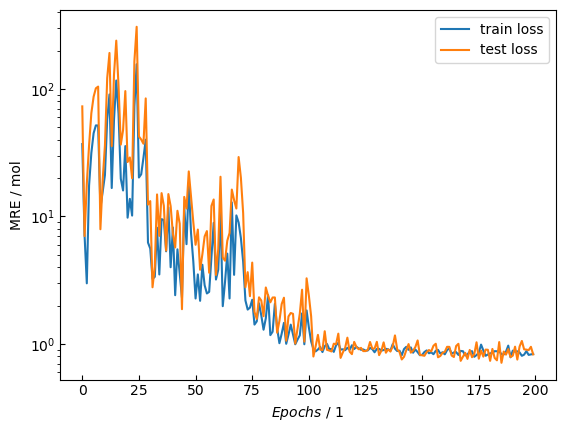

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'MRE / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

In [10]:
#### Parity Plot

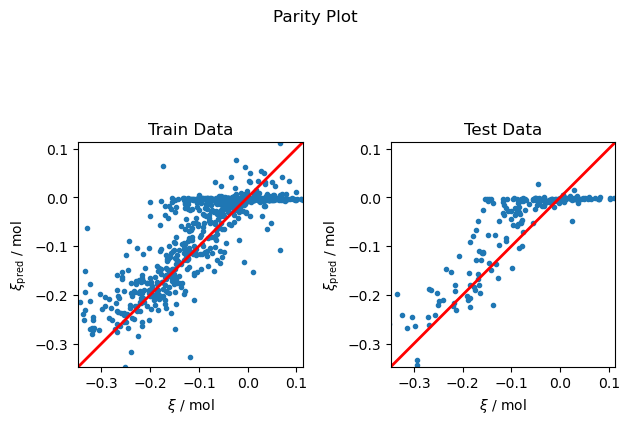

In [11]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2)

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].set_title('Test Data')


#plt.legend()
fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

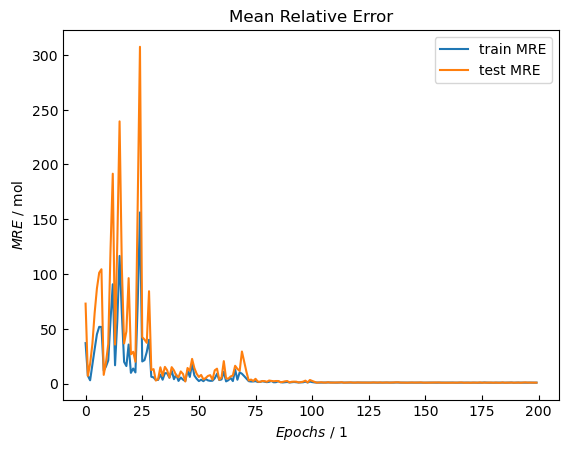

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

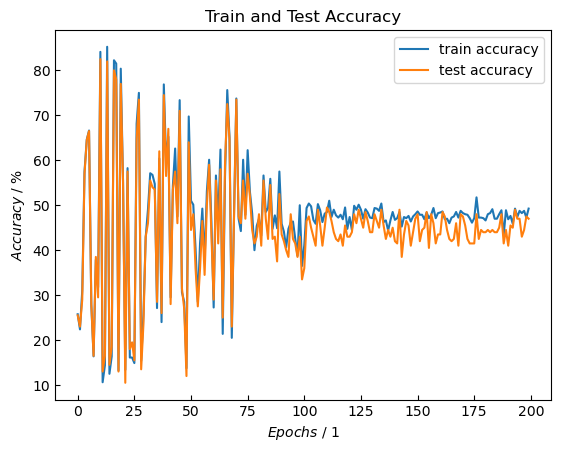

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.5012e+02, 1.5677e+02, 2.3388e-01, 4.2237e-01, 3.4375e-01],
        [8.5039e+02, 1.4001e+02, 7.7564e-01, 4.8499e-02, 1.7586e-01],
        [6.7671e+02, 2.0588e+02, 4.0774e-01, 5.3315e-01, 5.9102e-02],
        [7.2214e+02, 1.7722e+02, 1.0801e-02, 6.6074e-01, 3.2846e-01],
        [6.8419e+02, 1.2634e+02, 1.5571e-01, 5.5756e-01, 2.8673e-01],
        [7.8662e+02, 1.4209e+02, 1.3679e-01, 8.1887e-01, 4.4340e-02],
        [8.0522e+02, 1.7336e+02, 3.1051e-01, 3.2697e-01, 3.6251e-01],
        [7.7952e+02, 2.2463e+02, 1.2765e-01, 3.1127e-01, 5.6108e-01],
        [7.5613e+02, 2.3753e+02, 8.0149e-01, 1.7264e-01, 2.5869e-02],
        [8.2088e+02, 1.5333e+02, 6.2761e-01, 2.4678e-01, 1.2560e-01],
        [8.4941e+02, 1.5903e+02, 9.5226e-01, 1.0870e-02, 3.6873e-02],
        [7.6518e+02, 2.4319e+02, 6.8809e-01, 1.5334e-01, 1.5858e-01],
        [7.2963e+02, 1.5420e+02, 4.3237e-02, 9.3132e-01, 2.5444e-02],
        [8.2284e+02, 1.5734e+02, 9.6509e-02, 5.8688e-01, 3.1661e-01],
        [8.1156e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.7818, 1.3841, 0.7565, 0.6673, 0.9091], requires_grad=True),
 Parameter containing:
 tensor([ 0.1401,  0.2231, -0.1246,  0.0664,  0.0645], requires_grad=True),
 Parameter containing:
 tensor([[-3.1311e-02, -4.8329e-01,  4.3931e-02,  1.1362e-01,  6.2487e-02],
         [ 3.1785e-02, -7.5171e-01, -2.3888e-01, -1.1956e-02,  3.1278e-01],
         [ 1.3459e-01, -6.9119e-01, -1.7486e-02, -1.2602e-01,  3.7274e-01],
         [ 3.1638e-01, -6.5437e-02, -4.8508e-01, -9.5110e-02,  4.5568e-01],
         [ 1.1837e-02, -7.8011e-01,  5.5710e-02,  1.0238e-02,  3.3686e-01],
         [ 2.8618e-01, -1.8773e-01,  8.3594e-02, -5.6389e-02,  1.7299e-01],
         [-4.4786e-02, -5.8323e-01, -4.3537e-01, -1.4877e-01, -1.9610e-01],
         [-4.4050e-02, -1.0743e-02,  1.2260e-01, -1.4947e-01,  6.0649e-02],
         [ 1.3496e-01, -2.4994e-01,  1.3995e-01, -4.2939e-02, -3.1419e-01],
         [-2.4467e-01, -6.3473e-01, -6.0739e-02,  5.9563e-02,  2.3934e-02],
         [ 4.1326e-02,  

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4352, 0.8590, 0.5108, 0.5758, 0.0683],
        [0.8057, 0.9920, 0.5925, 0.9611, 0.5629]])
tensor([[-0.0020],
        [-0.0876]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.3996e+02, 1.5045e+02, 6.1881e-01, 2.2570e-01, 1.5548e-01],
        [7.5268e+02, 1.6032e+02, 9.8218e-01, 1.1587e-02, 6.2332e-03],
        [7.0954e+02, 2.0814e+02, 8.2530e-02, 6.8137e-01, 2.3610e-01],
        [6.5516e+02, 2.3000e+02, 2.9277e-01, 4.6182e-01, 2.4541e-01],
        [6.9925e+02, 1.1755e+02, 5.0936e-01, 1.9385e-01, 2.9679e-01],
        [7.6535e+02, 1.0744e+02, 3.2285e-01, 2.9224e-01, 3.8491e-01],
        [7.1103e+02, 1.8377e+02, 2.6334e-01, 4.7915e-01, 2.5752e-01],
        [8.4425e+02, 2.1180e+02, 4.3155e-01, 8.8767e-02, 4.7968e-01],
        [6.5068e+02, 1.5114e+02, 8.5562e-02, 4.8427e-01, 4.3017e-01],
        [6.8303e+02, 1.2941e+02, 2.4015e-01, 7.7096e-02, 6.8275e-01],
        [6.7881e+02, 1.6881e+02, 5.8301e-01, 2.1284e-01, 2.0415e-01],
        [7.8402e+02, 1.7302e+02, 6.3905e-01, 4.3015e-02, 3.1794e-01],
        [7.8489e+02, 1.2609e+02, 6.5320e-02, 7.3103e-01, 2.0365e-01],
        [7.5379e+02, 2.2449e+02, 4.9458e-01, 7.1706e-03, 4.9825e-01],
        [7.2320e+02,